# Cargamos Datos

In [26]:
import fastai
import torch
from fastai.vision import *
from shutil import copyfile
import os
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})

In [2]:
path = '/shared/pytorch-CycleGAN-and-pix2pix/results_TFG/CanRuti_Clinic_NoNormal/test_10/images'


In [3]:
variant = os.listdir('/shared/Datasets_Classification/Classification_CanRuti/VARIANT_LYMPHOCYTE')
atypical = os.listdir('/shared/Datasets_Classification/Classification_CanRuti/ATYPICAL_LYMPHOCYTE')
blast = os.listdir('/shared/Datasets_Classification/Classification_CanRuti/BLAST')

In [4]:
def catcher(x): return re.findall('([a-zA-Z]+_+[\d]+)', x)[0]


In [5]:
variant_png = [catcher(i)+'_fake_B.png' for i in variant]
atypical_png = [catcher(i)+'_fake_B.png' for i in atypical]
blast_png = [catcher(i)+'_fake_B.png' for i in blast]

In [6]:
#for i in variant_png:
#    copyfile(os.path.join(path,i), os.path.join("/shared/Datasets_Classification/CanRuti_Fake_Cyc_Epoch_10/VARIANT_LYMPHOCYTE", i))
#    
#for i in blast_png:
#    copyfile(os.path.join(path,i), os.path.join("/shared/Datasets_Classification/CanRuti_Fake_Cyc_Epoch_10/BLAST", i))
#    
#for i in atypical_png:
#    copyfile(os.path.join(path,i), os.path.join("/shared/Datasets_Classification/CanRuti_Fake_Cyc_Epoch_10/ATYPICAL_LYMPHOCYTE", i))
#    

In [7]:
folder_1 = os.listdir("/shared/Datasets_Classification/CanRuti_Fake_Cyc/ATYPICAL_LYMPHOCYTE")
folder_2 = os.listdir("/shared/Datasets_Classification/CanRuti_Fake_Cyc/VARIANT_LYMPHOCYTE")
folder_3 = os.listdir("/shared/Datasets_Classification/CanRuti_Fake_Cyc/BLAST")
dic_Classif = {
      'ATYPICAL_LYMPHOCYTE':len(folder_1),
      'VARIANT_LYMPHOCYTE':len(folder_2),
      'BLAST':len(folder_3)
     }

pd.DataFrame(dic_Classif, index=['N'])

ATYPICAL_LYMPHOCYTE  VARIANT_LYMPHOCYTE  BLAST
N                   47                  57     80

In [8]:
folder_classes = "/shared/Datasets_Classification/CanRuti_Fake_Cyc_Epoch_10"
tfms = get_transforms(flip_vert=True, max_warp=None, max_zoom=1.01, max_rotate=120, max_lighting=0.1)


#### Creación del DataBunch de las imágenes de Can Ruti Fake

Aunque haya una separación del 50 por ciento en cada set, solo se utilizará un conjunto de validación para el test, el de training se ignorará

In [9]:
df_train = pd.read_csv('/shared/can_ruti/train.csv')
df_train['x'] = df_train['x'].apply(lambda x: x.replace('.jpg', '_fake_B.png'))
df_train['z'] = False
df_train.head()

x      y      z
0  BLAST/BL_10600573_fake_B.png  BLAST  False
1  BLAST/BL_13076127_fake_B.png  BLAST  False
2  BLAST/BL_12630836_fake_B.png  BLAST  False
3  BLAST/BL_10600634_fake_B.png  BLAST  False
4  BLAST/BL_12630955_fake_B.png  BLAST  False

In [10]:
df_valid = pd.read_csv('/shared/can_ruti/validation.csv')
df_valid['x'] = df_valid['x'].apply(lambda x: x.replace('.jpg', '_fake_B.png'))
df_valid['z'] = True
df_valid.head()

x                    y     z
0  ATYPICAL_LYMPHOCYTE/LY_13166703_fake_B.png  ATYPICAL_LYMPHOCYTE  True
1  ATYPICAL_LYMPHOCYTE/LY_13103960_fake_B.png  ATYPICAL_LYMPHOCYTE  True
2                BLAST/BL_10600656_fake_B.png                BLAST  True
3   VARIANT_LYMPHOCYTE/LY_13130834_fake_B.png   VARIANT_LYMPHOCYTE  True
4                BLAST/BL_10600719_fake_B.png                BLAST  True

In [11]:
df_split = pd.concat([df_train, df_valid])
df_split = df_split.rename(columns={'x': 'name','y': 'label','z':'is_valid'})
df_split.head()

name  label  is_valid
0  BLAST/BL_10600573_fake_B.png  BLAST     False
1  BLAST/BL_13076127_fake_B.png  BLAST     False
2  BLAST/BL_12630836_fake_B.png  BLAST     False
3  BLAST/BL_10600634_fake_B.png  BLAST     False
4  BLAST/BL_12630955_fake_B.png  BLAST     False

In [12]:
folder_classes

'/shared/Datasets_Classification/CanRuti_Fake_Cyc_Epoch_10'

In [13]:
data = (ImageList.from_df(df_split, folder_classes) #Where to find the data? -> in path and its subfolders
        .split_from_df()         #How to split in train/valid? -> use the folders
        .label_from_folder()            #How to label? -> depending on the folder of the filenames
        .transform(tfms, size=224)       #Data augmentation? -> use tfms with a size of 64
        .databunch(num_workers=0)
        .normalize(imagenet_stats))   

In [14]:
data.batch_size = 20

#### Descripción del Conjunto de datos Can Ruti Fake

In [15]:
pd.DataFrame.from_dict({'Number of classes':[data.c],
'train_size':[len(data.train_ds)],
'valid_size':[len(data.valid_ds)]},
orient = 'index', columns=['N'])

N
Number of classes   3
train_size         92
valid_size         92

#### Conteo de clases del conjunto de training de datos Can Ruti Fake

train_ds = data.train_ds.to_df()
pd.DataFrame(train_ds['y'].value_counts()).rename(columns={'y':'N'})

#### Conteo de clases del conjunto de validación de datos Can Ruti Fake

valid_ds = data.valid_ds.to_df()
pd.DataFrame(valid_ds['y'].value_counts()).rename(columns={'y':'N'})

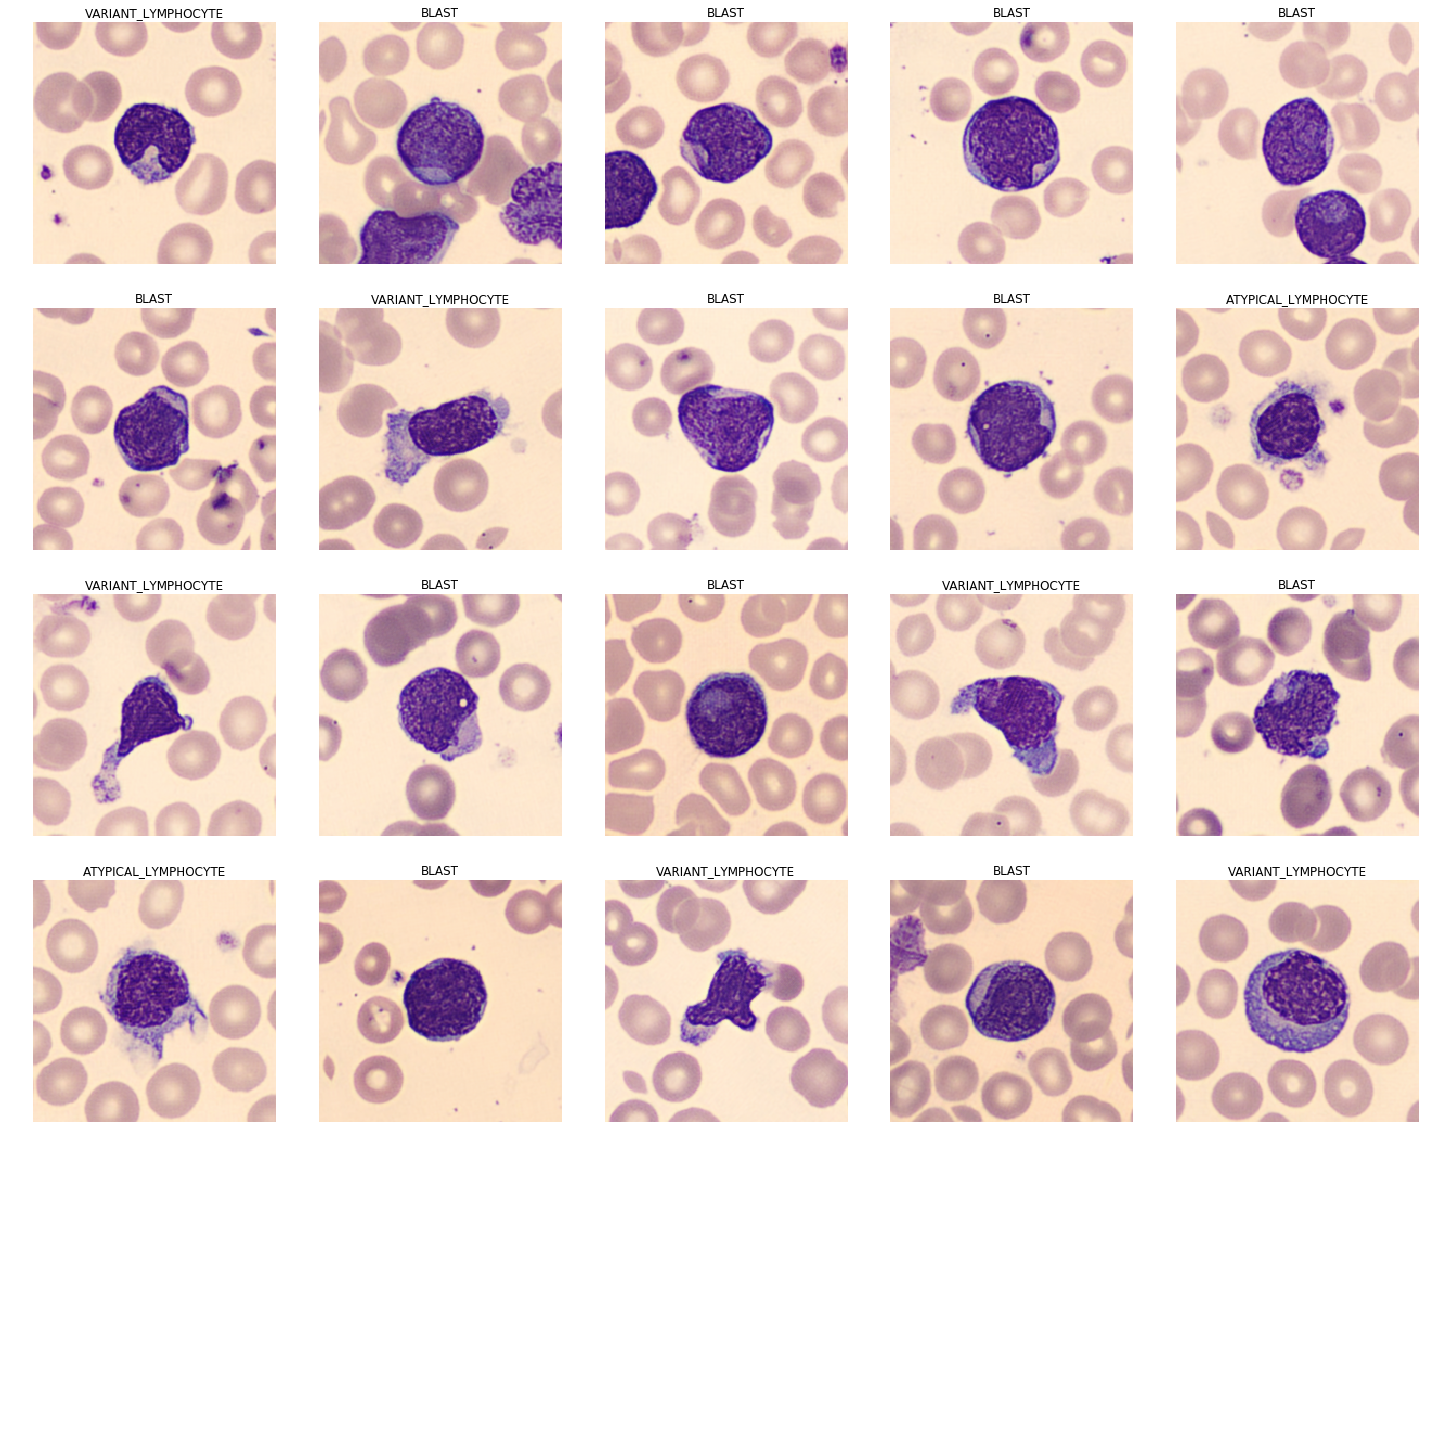

In [16]:
data.show_batch()


# Test Canruti Resnet 34 (Santi) Preentrenada en Clinic NoSind

Se crea un learner con datos auxilares del clinic pero se sustituye con el Databunch de CanRuti anterior para validar en CanRuti. Nótese que se incorporan los pesos del clínic con el método `.load()`

In [17]:
data.classes

['ATYPICAL_LYMPHOCYTE', 'BLAST', 'VARIANT_LYMPHOCYTE']

In [18]:
folder_model = "/shared/modelos"
learn = None
learn = load_learner(folder_model, 'export_Resnet34_3types_BAL_resampling_NoLGL_NoSIND.pkl')
learn.data.classes = data.classes


/opt/conda/envs/fastai/lib/python3.6/site-packages/torch/serialization.py:434: SourceChangeWarning: source code of class 'fastai.layers.AdaptiveConcatPool2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/opt/conda/envs/fastai/lib/python3.6/site-packages/torch/serialization.py:434: SourceChangeWarning: source code of class 'fastai.layers.Flatten' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


In [19]:
learn.data.classes

['ATYPICAL_LYMPHOCYTE', 'BLAST', 'VARIANT_LYMPHOCYTE']

In [20]:
learn.data = data

In [21]:
learn.data.batch_size = 20

In [22]:
gc.collect()

0

In [23]:
a = dict(zip(['loss', 'accuracy'], [[learn.validate()[0]],[learn.validate()[1].item()]]))
a

{'loss': [1.4386601], 'accuracy': [0.554347813129425]}

In [24]:
pd.DataFrame.from_dict(a).rename({0:'metrics'})

loss  accuracy
metrics  1.43866  0.554348

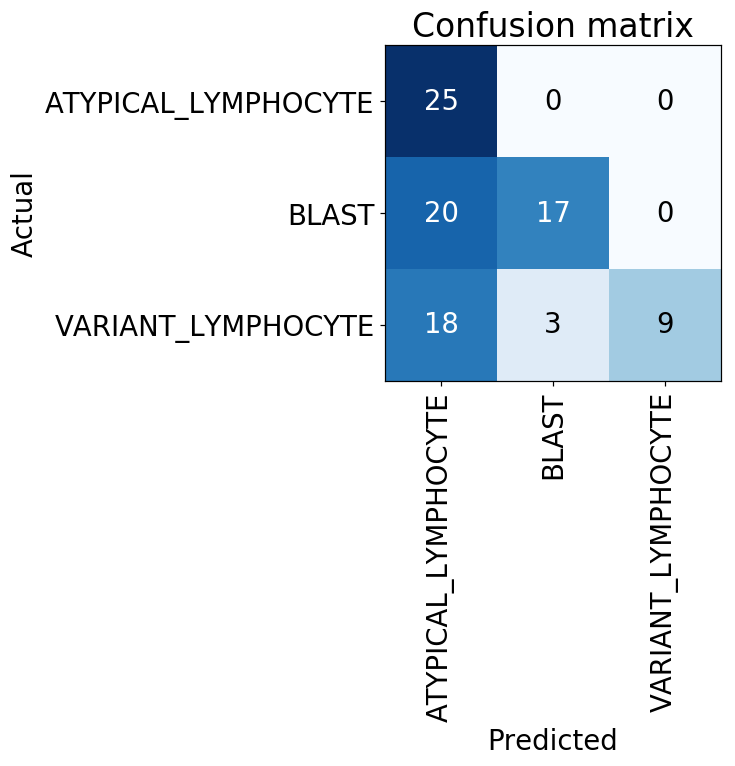

In [27]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
interp.plot_confusion_matrix(figsize=(7,7), dpi=110)

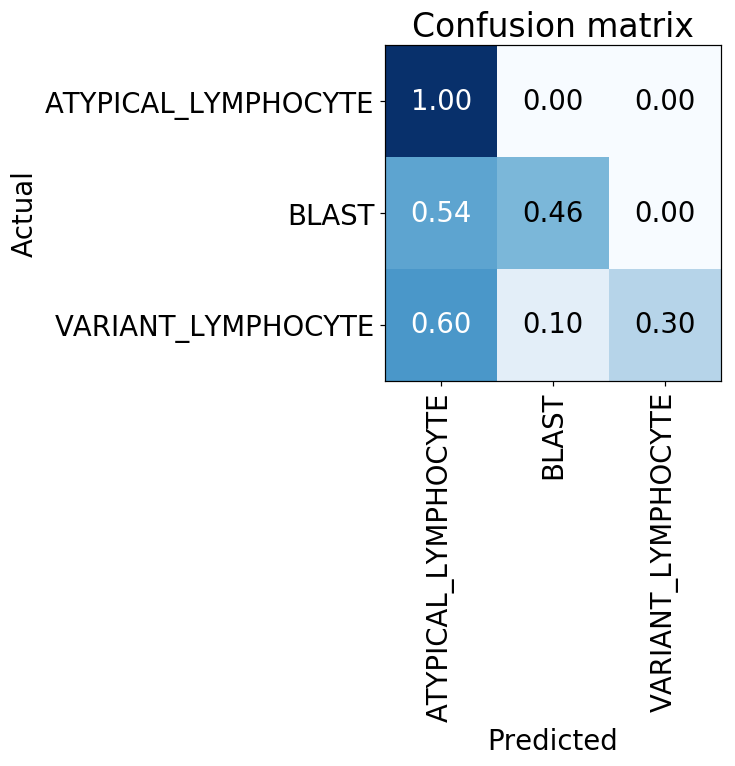

In [28]:
interp.plot_confusion_matrix(figsize=(7,7), dpi=110, normalize=True)

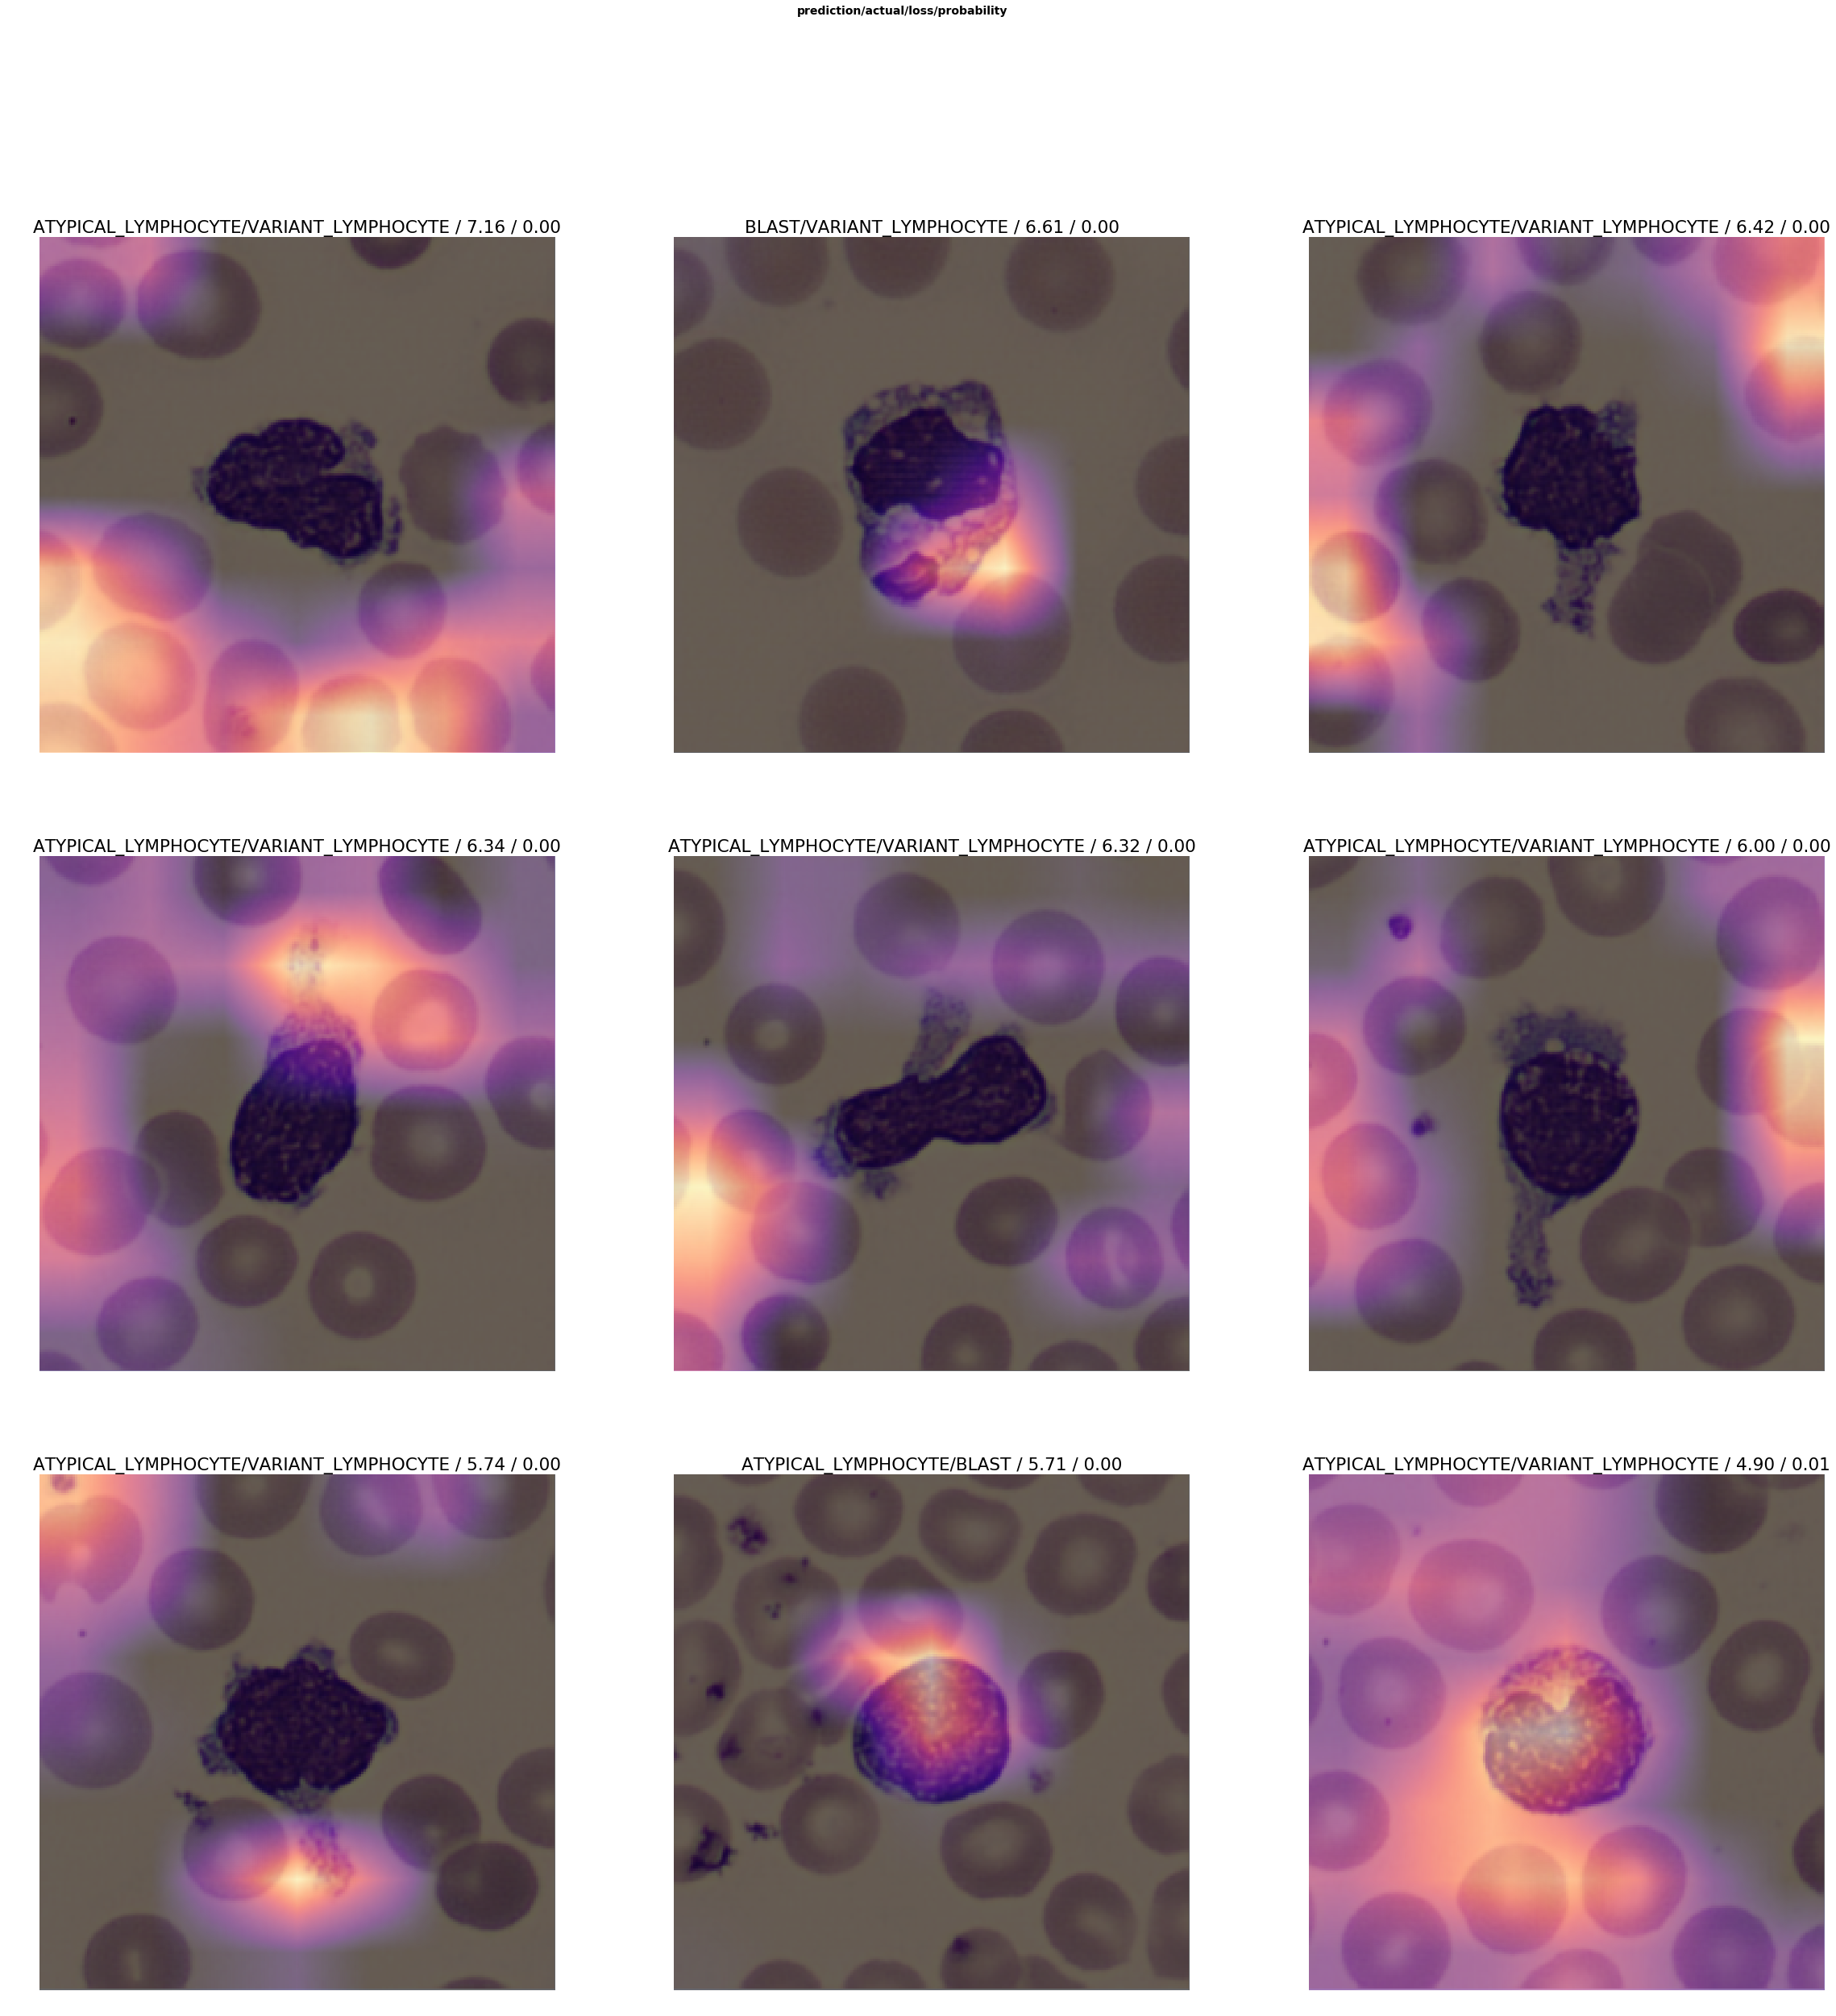

In [29]:
interp.plot_top_losses(9, largest=True, figsize=(40,40), heatmap=True)

In [31]:
learn.unfreeze()
learn.fit_one_cycle(3, max_lr = 3e-4)

In [32]:
learn.fit_one_cycle(3, max_lr = 3e-4)

In [33]:
learn.fit_one_cycle(3, max_lr = 3e-4)

In [34]:
learn.fit_one_cycle(3, max_lr = 3e-4)

In [35]:
learn.fit_one_cycle(3, max_lr = 3e-4)

In [36]:
learn.fit_one_cycle(3, max_lr = slice(3e-4))

In [37]:
learn.fit_one_cycle(3, max_lr = (3e-5))

In [38]:
learn.fit_one_cycle(3, max_lr = 3e-5)

In [39]:
learn.fit_one_cycle(3, max_lr = slice(3e-5))

In [40]:
learn.fit_one_cycle(3, max_lr = 3e-6)

In [41]:
learn.fit_one_cycle(3, max_lr = slice(3e-6))

In [42]:
learn.export('export_stage-2-NoSind-Fake_Cyc_3_Classes')


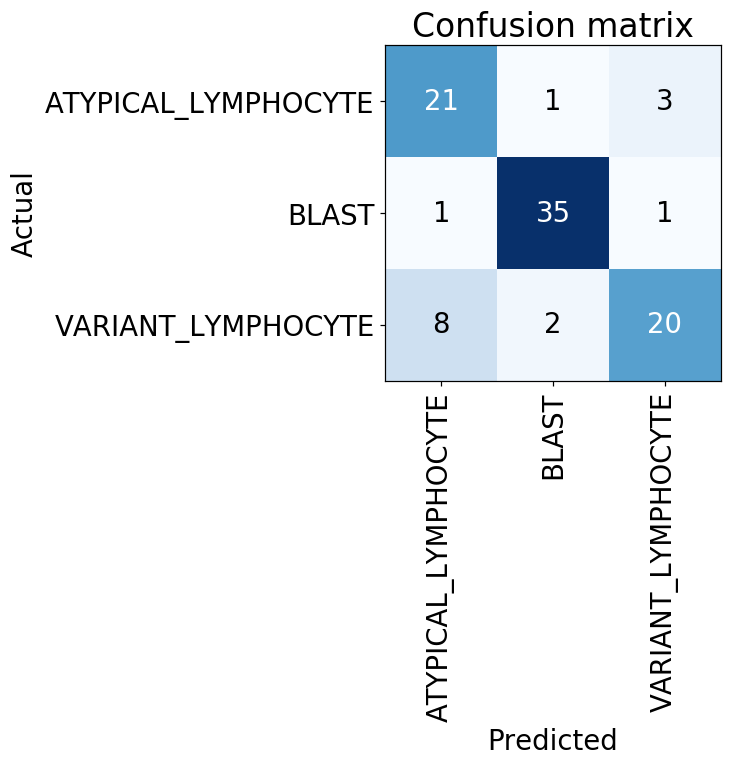

In [43]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
interp.plot_confusion_matrix(figsize=(7,7), dpi=110, norm_dec=2 )

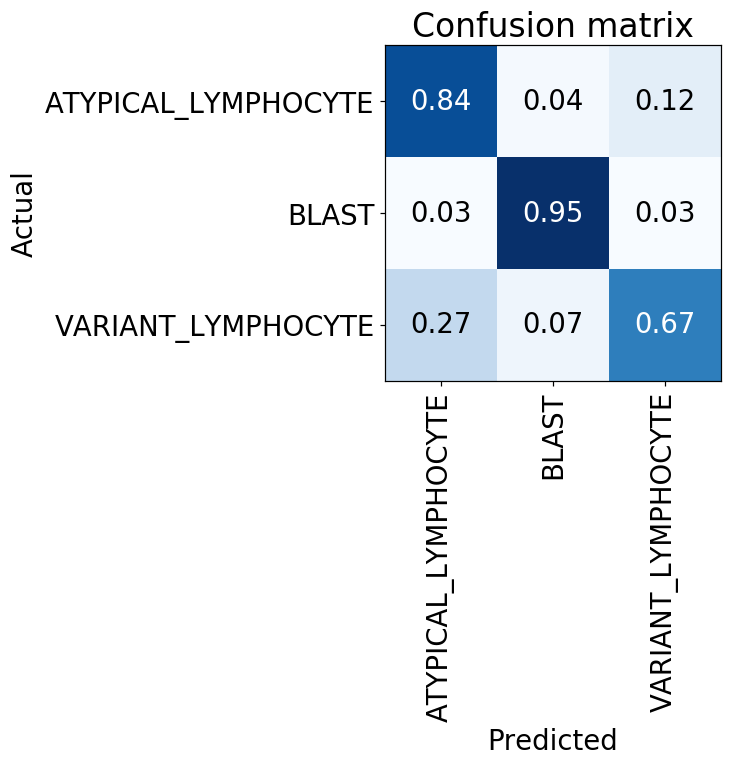

In [44]:
interp.plot_confusion_matrix(figsize=(7,7), dpi=110, normalize=True)

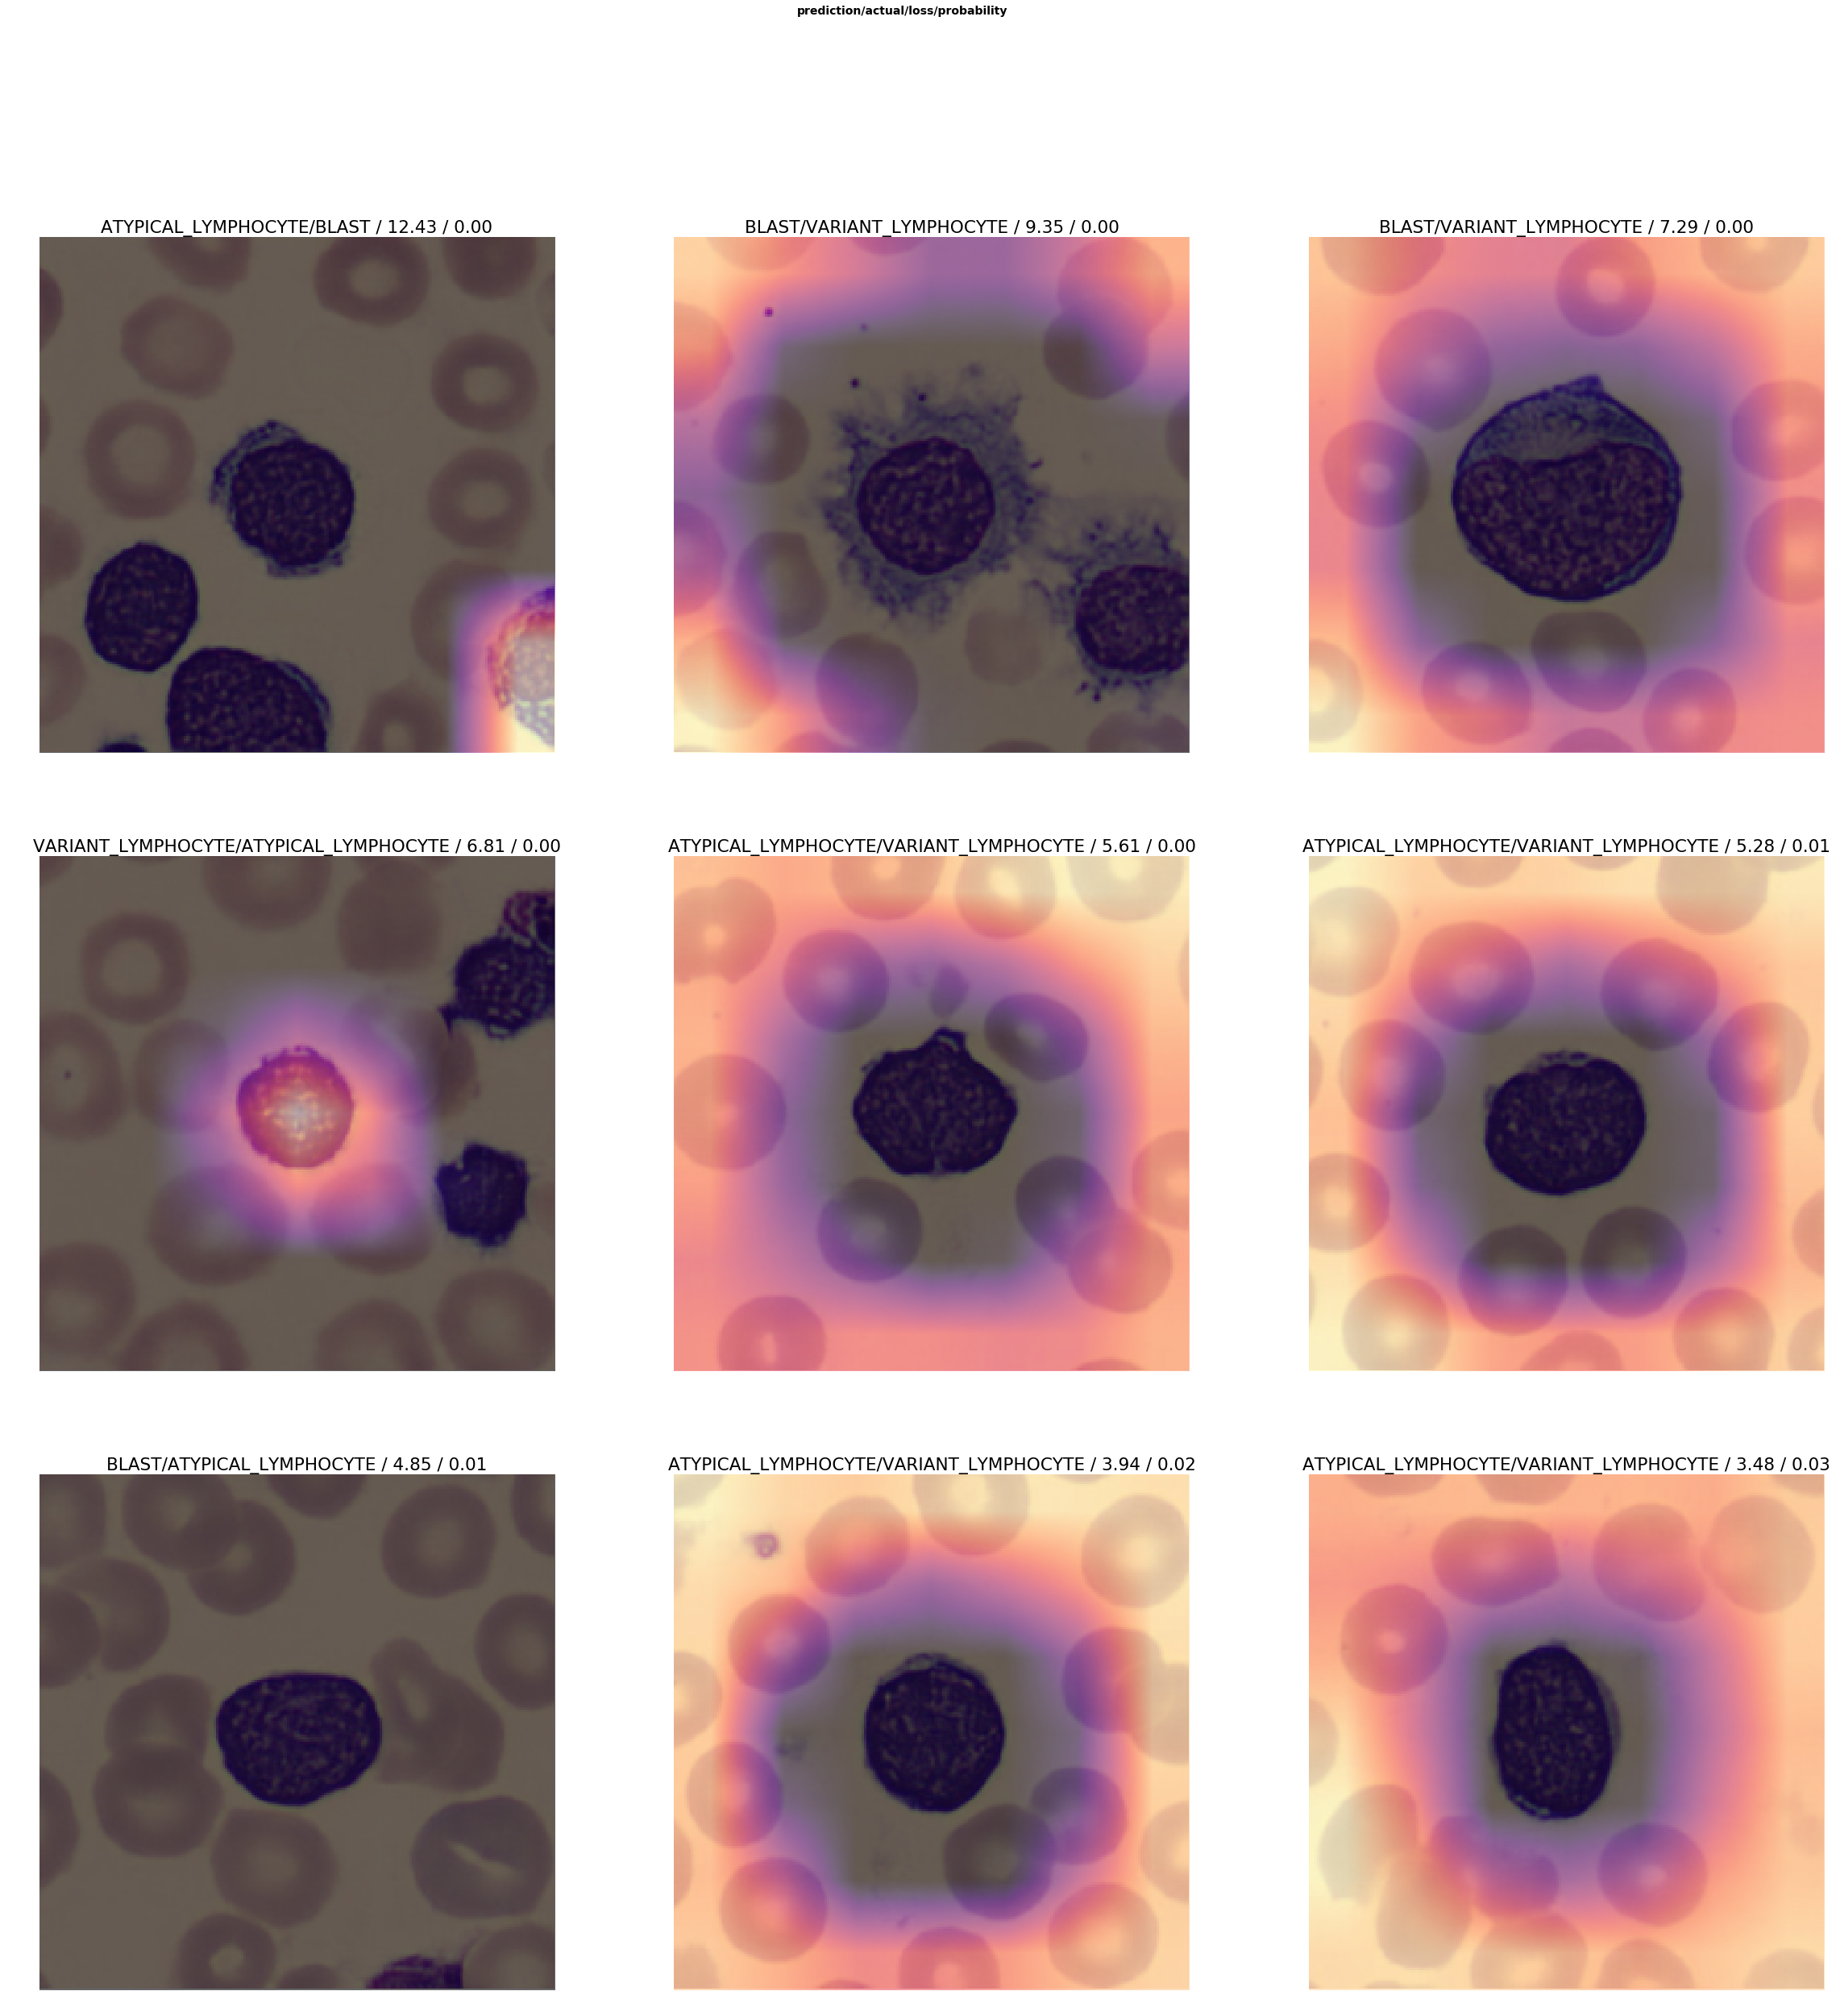

In [45]:
interp.plot_top_losses(9, largest=True, figsize=(40,40), heatmap=True)
